In [2]:
import pandas as pd
import numpy as np
import csv
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#results_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\monkey\\'
results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\'

csv_data_file_pfdl = results_folder + 'data_pfdl_fixon_1500ms_fixation_binned_50ms.csv'
with open(csv_data_file_pfdl, newline='') as f:
    reader = csv.reader(f)
    sua_list_pfdl = list(reader)
    
n_spike_trains_pfdl = len(sua_list_pfdl)
print('N spike_trains in PFdl fixON {}'.format(n_spike_trains_pfdl))

N spike_trains in PFdl fixON 33018


In [4]:
# transform list to an array and to a dataframe 
sua_array_pfdl = np.array(sua_list_pfdl)
print(sua_array_pfdl.shape)

bin_cols = ['bin_' + str(i) for i in range(sua_array_pfdl.shape[1]-3)]
sua_pfdl_df = pd.DataFrame(sua_array_pfdl, columns=['unit_id', 'trial_id','condition_id'] + bin_cols)
sua_pfdl_df = sua_pfdl_df.astype('int')
sua_pfdl_df

(33018, 33)


,unit_id,trial_id,condition_id,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,...,bin_20,bin_21,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29
0,0,0,0,1,1,0,0,3,0,1,...,0,0,1,0,0,0,0,3,1,0
1,0,1,0,1,1,1,1,0,1,0,...,0,0,1,0,0,0,0,0,2,1
2,0,2,0,1,0,0,1,0,0,0,...,1,2,1,0,1,0,1,1,0,1
3,0,3,0,0,2,2,3,1,1,4,...,3,2,1,2,1,3,3,1,1,0
4,0,4,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33013,543,4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
33014,543,15,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
33015,543,18,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33016,543,19,4,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
len(sua_pfdl_df['unit_id'].unique())

543

#### Plot some general plots with activity

In [ ]:
# average unit activity across trails and conditions

unit_average_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()
unit_average_df

In [ ]:
sns.heatmap(unit_average_df[bin_cols].values)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

for unit in range(len(unit_average_df)):
    axes.plot(unit_average_df[bin_cols].values[unit, :], lw=0.5, c='k', alpha=0.2)

sns.despine()

#### Calc acf as acf and as Pearson (per single trial and per average over trials and conditions)

In [9]:
acf_cols = ['acf_' + str(i) for i in range(11)]

In [ ]:
def my_autocorr_pearsonr(signal_, lag_=1, verbose=True):
    # autocorrelation for 1 lag, using pearsonr from scipy
    if verbose:
        print('Calc for lag {}, input length {}'.format(lag_, signal_.shape))

    r, p = pearsonr(signal_[lag_:], signal_[:-lag_])
    
    if verbose:
        print('ac_lag {}'.format(r))
    return r  

def my_acf_pearsonr(signal_, nlags=2, verbose=True):
    # acf
    acf = [1] 
    for i in range(1, (nlags + 1)):
        acf.append(my_autocorr_pearsonr(signal_, i, verbose)) 
    return np.array(acf)

In [ ]:
acf_proper_l = []

for unit in range(len(sua_pfdl_df)):
    acf_proper = acf(sua_pfdl_df[bin_cols].values[unit, :], nlags=10)
    acf_proper_l.append(acf_proper)

In [ ]:
acf_proper_df = pd.DataFrame(np.array(acf_proper_l), columns=acf_cols)
acf_proper_df.insert(0, 'unit_id', sua_pfdl_df['unit_id'].values)
acf_proper_df.insert(1, 'trial_id', sua_pfdl_df['trial_id'].values)
acf_proper_df

In [ ]:
acf_proper_trial_mean_l = []

for unit in range(len(unit_average_df)):
    acf_proper_trial_mean = acf(unit_average_df[bin_cols].values[unit, :], nlags=10)
    acf_proper_trial_mean_l.append(acf_proper_trial_mean)

In [ ]:
acf_proper_trial_mean_df = pd.DataFrame(np.array(acf_proper_trial_mean_l), columns=acf_cols)
acf_proper_trial_mean_df.insert(0, 'unit_id', unit_average_df['unit_id'].values)
acf_proper_trial_mean_df

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

for acf_ in range(len(acf_proper_trial_mean_df)):
    axes[0].plot(acf_proper_trial_mean_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[0].plot(np.nanmean(acf_proper_trial_mean_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[0].axhline(y=0, lw=0.5, color='k')
axes[0].axhline(y=1/np.e, lw=0.5, color='k')

for acf_ in range(len(acf_proper_df)):
    axes[1].plot(acf_proper_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[1].plot(np.nanmean(acf_proper_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[1].axhline(y=0, lw=0.5, color='k')

sns.despine()

In [ ]:
acf_pearsonr_l = []

for unit in range(len(sua_pfdl_df)):
    acf_pearsonr = my_acf_pearsonr(sua_pfdl_df[bin_cols].values[unit, :], nlags=10, verbose=False)
    acf_pearsonr_l.append(acf_pearsonr)

acf_pearsonr_df = pd.DataFrame(np.array(acf_pearsonr_l), columns=acf_cols)
acf_pearsonr_df.insert(0, 'unit_id', sua_pfdl_df['unit_id'].values)
acf_pearsonr_df.insert(1, 'trial_id', sua_pfdl_df['trial_id'].values)
acf_pearsonr_df

In [ ]:
acf_pearsonr_trial_mean_l = []

for unit in range(len(unit_average_df)):
    acf_pearsonr_trial_mean = my_acf_pearsonr(unit_average_df[bin_cols].values[unit, :], nlags=10, verbose=False)
    acf_pearsonr_trial_mean_l.append(acf_pearsonr_trial_mean)

acf_pearsonr_trial_mean_df = pd.DataFrame(np.array(acf_pearsonr_trial_mean_l), columns=acf_cols)
acf_pearsonr_trial_mean_df.insert(0, 'unit_id', unit_average_df['unit_id'].values)
acf_pearsonr_trial_mean_df

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

for acf_ in range(len(acf_pearsonr_trial_mean_df)):
    axes[0].plot(acf_pearsonr_trial_mean_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[0].plot(np.nanmean(acf_pearsonr_trial_mean_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[0].axhline(y=0, lw=0.5, color='k')
axes[0].axhline(y=1/np.e, lw=0.5, color='k')

for acf_ in range(len(acf_pearsonr_df)):
    axes[1].plot(acf_pearsonr_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[1].plot(np.nanmean(acf_pearsonr_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[1].axhline(y=0, lw=0.5, color='k')

sns.despine()

#### Calc acf as in Siegle (they use Pearson)

In [6]:
def acf_trial_pesrsonr(trials_time_series_2d, nlags_):
    time_series_a = trials_time_series_2d[:, :nlags_]
    nbins = time_series_a.shape[1]
    print(nbins)
    rsc_matrix = np.zeros((nbins, nbins))

    for i in np.arange(nbins-1):
        for j in np.arange(i+1, nbins): # filling i-th row
            r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
            rsc_matrix[i, j] = r
    np.fill_diagonal(rsc_matrix, 1)
            
    acf_average = np.zeros((nbins,))
    for i in range(nbins):
        acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
                
    return rsc_matrix, acf_average

In [18]:
# get all trials for a neuron
sua_pfdl_df_trial_counts = sua_pfdl_df.groupby(by='unit_id', as_index=False)['trial_id'].count().sort_values(by='trial_id')
unit_id_20_trials = sua_pfdl_df_trial_counts.query('trial_id >= 20')['unit_id'].values
len(unit_id_20_trials)

499

In [22]:
unit_id_l = sua_pfdl_df['unit_id'].unique()
len(unit_id_l)

543

In [23]:
nlags_ = 20
acf_average_trial_pearsonr_l = []
rsc_matrix_l = []

unit_id_l = sua_pfdl_df['unit_id'].unique()
#unit_id_l = unit_id_20_trials
unit_id_calc_l = []

for unit in unit_id_l:
    sua_pfdl_one_trial_df = sua_pfdl_df.query('unit_id == @unit')
    rsc_matrix, acf_average = acf_trial_pesrsonr(sua_pfdl_one_trial_df[bin_cols].values, nlags_)

    acf_average_trial_pearsonr_l.append(acf_average)
    rsc_matrix_l.append(rsc_matrix)
    unit_id_calc_l.append(unit)

20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correla

20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20
20
20
20
20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that


20
20
20
20
20


C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(time_series_a[:,i], time_series_a[:,j], ) # todo here use sttc - do not think that I can do that
C:\Users\ipoch\AppData\Local\Temp\ipykernel_38036\1577713764.py:15: RuntimeWarning: Mean of empty slice
  acf_average[i] = np.nanmean(np.diag(rsc_matrix, k=i))


ValueError: x and y must have length at least 2.

In [24]:
acf_cols = ['acf_' + str(i) for i in range(20)]

acf_average_trial_pearsonr_df = pd.DataFrame(np.array(acf_average_trial_pearsonr_l), columns=acf_cols)
acf_average_trial_pearsonr_df.insert(0, 'unit_id', unit_id_calc_l)
acf_average_trial_pearsonr_df

,unit_id,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,...,acf_10,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18,acf_19
0,0,1.0,0.443787,0.429808,0.374760,0.333984,0.287734,0.240484,0.189922,0.194006,...,0.192847,0.148964,0.216269,0.151006,0.159405,0.112679,0.020760,0.038556,0.046108,-0.052432
1,1,1.0,0.005432,0.069626,-0.009532,0.027993,0.051967,0.029365,0.119701,-0.058856,...,-0.056264,0.066109,-0.049954,0.124875,-0.049265,-0.046850,-0.040645,-0.040116,-0.044426,NaN
2,2,1.0,0.061446,0.036480,0.032609,-0.006591,0.043266,0.069176,0.006825,0.005949,...,-0.016844,0.008550,0.024759,-0.003741,0.000973,0.222765,0.063553,-0.084937,0.094580,-0.113666
3,3,1.0,0.436855,0.391458,0.371095,0.311763,0.294205,0.312247,0.282377,0.260343,...,0.266865,0.243661,0.274786,0.217886,0.234229,0.208189,0.152333,0.194667,0.227410,0.222422
4,4,1.0,0.124393,0.146276,0.066471,0.046590,0.025512,0.008332,0.029639,0.023872,...,0.000327,0.014934,-0.006864,0.030143,-0.017576,-0.023822,0.009294,-0.075483,0.031661,0.021984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,303,1.0,0.250782,0.156890,0.062510,0.020633,-0.021831,-0.022906,0.010070,0.027379,...,0.121107,0.118254,0.133425,0.013754,0.029759,-0.017628,-0.017440,0.017490,-0.065174,-0.171470
303,304,1.0,0.120119,0.078613,0.074280,0.021449,0.008431,-0.014555,0.001820,0.019650,...,0.010652,0.052728,0.055383,0.021249,-0.024030,0.011228,-0.021013,-0.015148,0.155629,0.003137
304,305,1.0,0.181014,0.115253,0.173308,0.048053,0.016985,0.041150,-0.012609,0.003237,...,-0.014800,0.013217,0.013137,-0.070459,-0.016077,-0.033108,-0.049765,-0.033764,0.047806,0.012233
305,306,1.0,0.028617,-0.063985,0.183595,0.072761,-0.084683,-0.080845,0.720588,0.110022,...,-0.055556,-0.080845,-0.093112,-0.084683,-0.080845,-0.055556,-0.068200,-0.068200,-0.055556,NaN


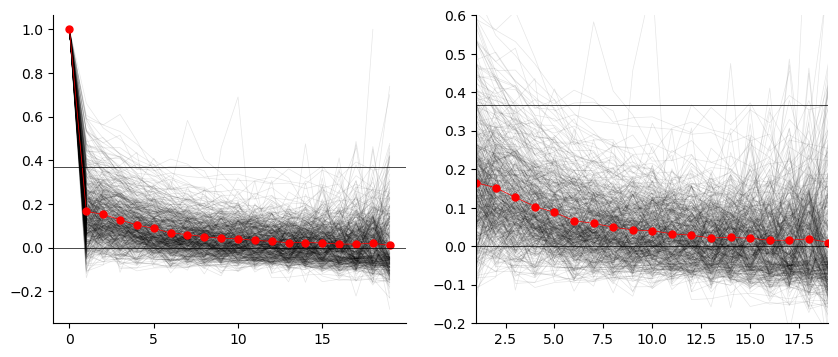

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

for acf_ in range(len(acf_average_trial_pearsonr_df)):
    axes[0].plot(acf_average_trial_pearsonr_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[0].plot(np.nanmean(acf_average_trial_pearsonr_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[0].axhline(y=0, lw=0.5, color='k')
axes[0].axhline(y=1/np.e, lw=0.5, color='k')

for acf_ in range(len(acf_average_trial_pearsonr_df)):
    axes[1].plot(acf_average_trial_pearsonr_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[1].plot(np.nanmean(acf_average_trial_pearsonr_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[1].axhline(y=0, lw=0.5, color='k')
axes[1].axhline(y=1/np.e, lw=0.5, color='k')
axes[1].set_xlim([1,19])
axes[1].set_ylim([-0.2,0.6])

sns.despine()

In [ ]:
sns.heatmap(rsc_matrix)